In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

# Asset Universe and Market Caps

In [3]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "MSFT", "AAPL", "AMD"] # Initial asset universe
start_date = '2013-01-01'
end_date = '2024-01-01'

In [36]:
data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("./Data/historical_data.csv")

closing_prices = data["Adj Close"]

returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    # VOO is Vanguard S&P 500 ETF
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]
    # market_returns = np.log(market_prices / market_prices.shift(1)).dropna() 

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)  # Get market cap, with None if missing

    return market_prices, market_caps

[*********************100%***********************]  7 of 7 completed


In [20]:
closing_prices.tail()

Ticker,AAPL,AMD,AMZN,META,MSFT,NVDA,TSLA
Date,,,,,,,
2023-12-22 00:00:00+00:00,192.656174,139.600006,153.419998,352.329163,371.799713,48.819527,252.539993
2023-12-26 00:00:00+00:00,192.108856,143.410004,153.410004,353.764832,371.879120,49.268425,256.609985
2023-12-27 00:00:00+00:00,192.208359,146.070007,153.339996,356.755859,371.293518,49.406395,261.440002
2023-12-28 00:00:00+00:00,192.636292,148.759995,153.380005,357.244415,372.494507,49.511375,253.179993
2023-12-29 00:00:00+00:00,191.591385,147.410004,151.940002,352.897491,373.248871,49.511375,248.479996


# Define Data for Markov-Switching

[*********************100%***********************]  1 of 1 completed


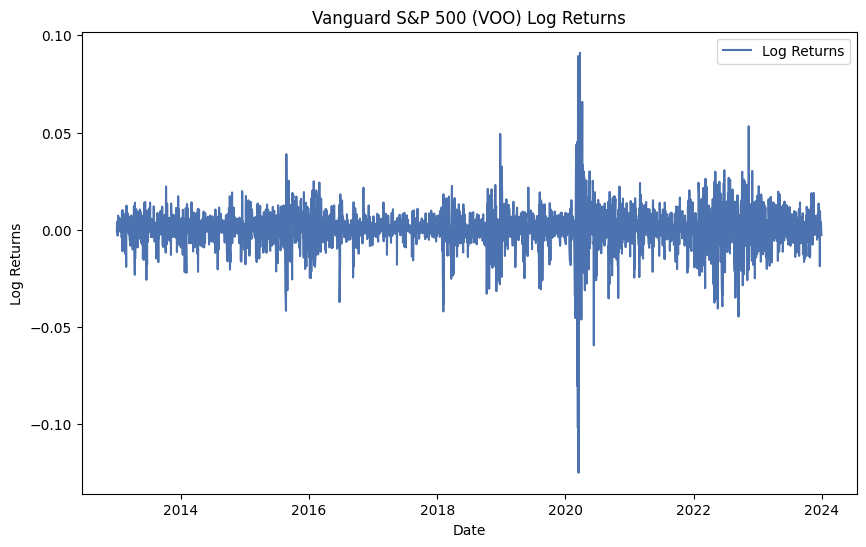

In [6]:
# Separate data for markov switching
etf_data = yf.download('VOO', start=start_date, end=end_date)
etf_data['Returns'] = np.log(etf_data['Close'] / etf_data['Close'].shift(1))
etf_data = etf_data.dropna()
etf_data.to_csv("./Data/VOO_data.csv")

def plot_log_returns(etf_data):
    plt.figure(figsize=(10,6))
    plt.plot(etf_data.index, etf_data['Returns'], label='Log Returns')
    plt.title('Vanguard S&P 500 (VOO) Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend()
    plt.show()

plot_log_returns(etf_data)

# Construct Regime Switching Model

c:\Users\chana\OneDrive\Documents\University of Liverpool\Dissertation\IT_Artifact\Black_Litterman_Risk_Parity_Portfolio_Optimisation\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                Returns   No. Observations:                 2767
Model:               MarkovRegression   Log Likelihood                9207.292
Date:                Mon, 25 Nov 2024   AIC                         -18402.584
Time:                        17:46:44   BIC                         -18367.031
Sample:                             0   HQIC                        -18389.743
                               - 2767                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      7.827      0.000       0.001       0.001
sigma2       3.22e-05   1.73e-06     18.632      0.0

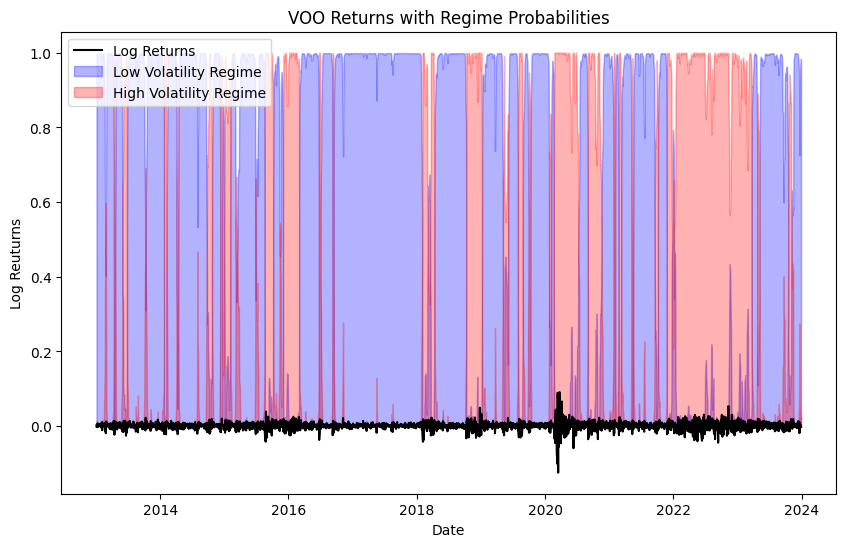

In [7]:
def fit_markov_regression(etf_data, k_regimes=2, switching_variance=True):
    model = MarkovRegression(etf_data['Returns'], k_regimes=k_regimes, switching_variance=switching_variance)
    results = model.fit()
    print(results.summary())
    
    return results, results.summary()

results, summary = fit_markov_regression(etf_data)

# To visalise when the market is in bull/bear periods. 
# Can see the likelihood of each one occuring using smoothed probabilities
def plot_regime_probabilities(etf_data):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(etf_data. index, etf_data['Returns'], label='Log Returns', color='black')
    
    ax.fill_between(etf_data.index, 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
    ax.fill_between(etf_data.index, 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime') # Any red sections show the market in high volatility period

    ax.set_title('VOO Returns with Regime Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel("Log Reuturns")
    ax.legend(loc='upper left')
    plt.show()

plot_regime_probabilities(etf_data)

In [8]:
etf_data['Regime_0_Prob'] = results.smoothed_marginal_probabilities[0]
etf_data['Regime_1_Prob'] = results.smoothed_marginal_probabilities[1]

# Get individual asset data
asset_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
asset_returns = np.log(asset_data / asset_data.shift(1)).dropna()

# Ensure indices have the same datetime format
etf_data.index = etf_data.index.tz_localize(None)
asset_returns.index = asset_returns.index.tz_localize(None)

# Align regime probabilities with asset_returns
aligned_probs = etf_data[['Regime_0_Prob', 'Regime_1_Prob']].reindex(asset_returns.index, method='ffill').dropna()

# Regime-specific covariance matrices
regime_0_data = asset_returns[aligned_probs['Regime_0_Prob'] > 0.5]
regime_1_data = asset_returns[aligned_probs['Regime_1_Prob'] > 0.5]

regime_0_cov = regime_0_data.cov()
regime_1_cov = regime_1_data.cov()

# Combine regime-specific covariance matrices dynamically based on probabilities
def get_dynamic_cov_matrix(aligned_probs, regime_0_cov, regime_1_cov):
    return (
        aligned_probs['Regime_0_Prob'].values[:, None, None] * regime_0_cov.values +
        aligned_probs['Regime_1_Prob'].values[:, None, None] * regime_1_cov.values
    )

# Get the dynamic covariance matrix for each time step
dynamic_cov_matrices = get_dynamic_cov_matrix(aligned_probs, regime_0_cov, regime_1_cov)

# Use the average covariance matrix as a proxy for the Black-Litterman model
average_dynamic_cov = np.mean(dynamic_cov_matrices, axis=0)
average_dynamic_cov = pd.DataFrame(average_dynamic_cov, index=tickers, columns=tickers)

# Calculate Market Implied Returns (Priors)
market_caps = asset_data.iloc[-1] * 1e6  # Assume market caps proportional to prices

C:\Users\chana\AppData\Local\Temp\ipykernel_13260\1356774314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_data['Regime_0_Prob'] = results.smoothed_marginal_probabilities[0]
C:\Users\chana\AppData\Local\Temp\ipykernel_13260\1356774314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etf_data['Regime_1_Prob'] = results.smoothed_marginal_probabilities[1]
[*********************100%***********************]  7 of 7 completed


# Plot Covariance Matrix

<Axes: >

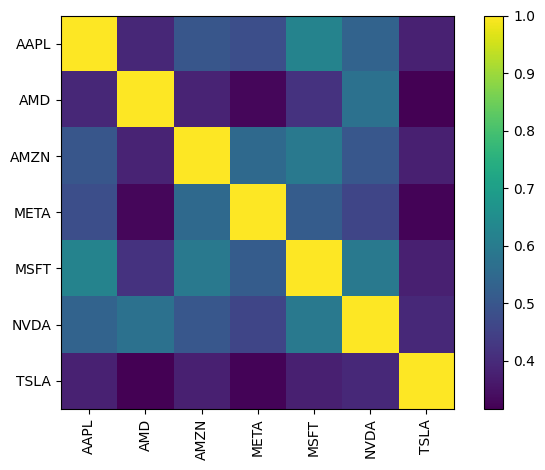

In [37]:
# Standard Covariance
covariance_matrix = returns.cov()
plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [26]:
covariance_matrix

Ticker,AAPL,AMD,AMZN,META,MSFT,NVDA,TSLA
Ticker,,,,,,,
AAPL,0.000321,0.000252,0.000184,0.000209,0.000189,0.000267,0.000243
AMD,0.000252,0.001274,0.000283,0.000284,0.000252,0.000571,0.000403
AMZN,0.000184,0.000283,0.000421,0.000273,0.000206,0.000288,0.000276
META,0.000209,0.000284,0.000273,0.000586,0.000211,0.000311,0.000279
MSFT,0.000189,0.000252,0.000206,0.000211,0.000286,0.000281,0.000227
NVDA,0.000267,0.000571,0.000288,0.000311,0.000281,0.000780,0.000395
TSLA,0.000243,0.000403,0.000276,0.000279,0.000227,0.000395,0.001274


# Calculate Delta and Priors

[*********************100%***********************]  1 of 1 completed


<Axes: ylabel='Ticker'>

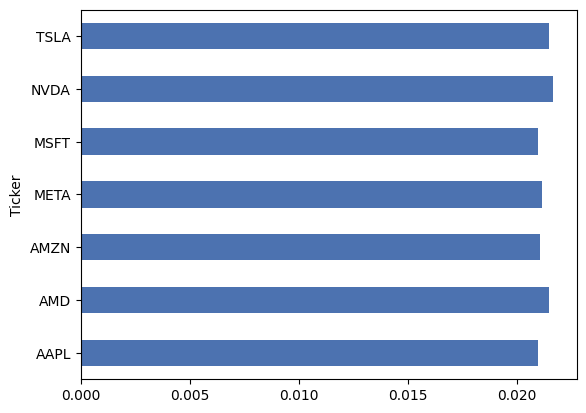

In [ ]:
# Standard delta and prior
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

market_caps
market_prices
prior.plot.barh()

# Markov delta and prior
markov_delta = black_litterman.market_implied_risk_aversion(etf_data['Returns'])
markov_prior = black_litterman.market_implied_prior_returns(market_caps, markov_delta, risk_models.sample_cov(asset_returns))

markov_prior.plot.barh()

print("Market prices (VOO):")
print(market_prices.tail())
print("Market caps:")
print(market_caps)
print("Standard market implied risk aversion (Delta):", delta)

print("Markov-adjusted market implied risk aversion (Delta):", markov_delta)

# Custom Fear Greed Index

In [19]:
# indicators to define:
# done - Stock Price Momentum: A measure of the S&P 500 versus its 125-day moving average (MA)
# done - Stock Price Strength: The number of stocks hitting 52-week highs versus those hitting 52-week lows on the New York Stock Exchange (NYSE).
# done - Stock Price Breadth: Analyzing the trading volumes in rising stocks against declining stocks.

# todo: Put and Call Options: The extent to which put options lag behind call options, signifying greed, or surpasses them, indicating fear.
# todo: Junk Bond Demand: Measures the spread between yields on investment-grade bonds and junk bonds.
# todo: Market Volatility: The CBOE's Volatility Index (VIX) based on a 50-day MA.
# todo: Safe Haven Demand: The difference in returns for stocks versus treasuries.

def get_fear_greed(tickers, start_date='2023-01-01', end_date='2024-01-01'):
    fear_greed_scores_dict = {}

    for ticker in tickers:
        try:
            # calculate each indicator for the stock
            rsi = calculate_stock_rsi(ticker, start_date=start_date, end_date=end_date).iloc[-1]['RSI']
            price_strength, high, low, current_price = calculate_stock_price_strength(ticker)
            breadth_data = calculate_stock_price_breadth(ticker, start=start_date, end=end_date)

            # normalise each indicator (as rsi is from 0-100 etc)
            normalised_rsi = rsi / 100
            normalised_price_strength = price_strength
            latest_breadth_ratio = breadth_data['breadth_ratio'].iloc[-1]
            normalised_breadth = min(max(latest_breadth_ratio / 2, 0), 1)

            # weights for each indicator
            rsi_weight = 0.4
            price_strength_weight = 0.3
            breadth_weight = 0.3

            # calculate the FG score
            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error has occured for {ticker}: {error}")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

# Relative Strength Index (RSI)
def calculate_stock_rsi(ticker, period=14, start_date="2023-01-01", end_date="2024-01-01"):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data['Change'] = stock_data['Close'].diff()
    stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
    stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

    stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
    stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

    stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
    stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

    return stock_data[['Close', 'RSI']].dropna()

def calculate_stock_price_strength(ticker):
    stock_data = yf.Ticker(ticker)
    stock_history = stock_data.history(period="1y")

    high = stock_history['Close'].max()
    low = stock_history['Close'].min()
    current_price = stock_history['Close'].iloc[-1]

    proximity_to_high = (current_price - low) / (high - low)
    return proximity_to_high, high, low, current_price

def calculate_stock_price_breadth(ticker, start, end):
    close_data = data['Close']
    volume_data = yf.download(ticker, start=start, end=end)['Volume']

    price_change = data.pct_change().fillna(0)
    results = pd.DataFrame(index=data.index)

    results['rising_volume'] = np.where(price_change > 0, volume_data, 0)
    results['declining_volume'] = np.where(price_change < 0, volume_data, 0)

    results['breadth_ratio'] = results['rising_volume'].sum() / results['declining_volume'].sum()
    return results

tickers = ['TSLA'] # use any here. need to be using full asset universe for investor views
fear_greed_scores = get_fear_greed(tickers, start_date='2023-01-01', end_date='2024-01-01')
print(fear_greed_scores) # 0-1, higher score is greedier

# def calculate_put_call_ratio():
# High Put-Call Ratio is Bearish
# Low Put-Cal Ratio is Bullish

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

An error has occured for TSLA: operands could not be broadcast together with shapes (2768,42) (250,) () 
{'TSLA': None}


# Plot Fear-Greed Indicators

In [20]:
def plot_stock_rsi(ticker: str, start_date: str = "2023-01-01", end_date: str = "2024-01-01"):
    rsi_data = calculate_stock_rsi(ticker, start_date=start_date, end_date=end_date)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'{ticker} Relative Strength Index (RSI)')
    
    ax1.plot(rsi_data.index, rsi_data['RSI'], label='RSI', color='purple')
    ax1.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax1.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax1.set_ylabel('RSI')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    
    plt.show()

def plot_stock_price_strength(ticker: str):
    proximity_to_high, high, low, current_price = calculate_stock_price_strength(ticker)

    stock_data = yf.Ticker(ticker)
    stock_history = stock_data.history(period="1y")

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f'{ticker} Stock Price and Strength Relative to 52-Week Range')
    
    ax1.plot(stock_history.index, stock_history['Close'], label='Close price', color='blue')
    ax1.axhline(high, color='red', linestyle='--', label='52 week high')
    ax1.axhline(low, color='green', linestyle='--', label='52 week low')
    ax1.scatter(stock_history.index[-1], current_price, color='purple', label=f'Current Price (Proximity: {proximity_to_high:.2f})')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Date')
    ax1.legend(loc='upper left')
    
    plt.show()

# Need plot for calculate_stock_price_breadth()

# plot_stock_rsi('NVDA') # not working
# plot_stock_price_strength('NVDA') # change this to plot multiple

# Generate Investor Views

In [21]:
# convert FG score into views
bullish_threshold = 70
bearish_threshold = 30

fg_based_views = []
fg_based_confidences = []

for i, stock in enumerate(tickers):
    stock_score = get_fear_greed(tickers)

    if stock_score > bullish_threshold:
        view_returns = 0.02 + (stock_score - bullish_threshold) * 0.0001
    elif stock_score < bearish_threshold:
        view_returns = -0.02 + (bearish_threshold - stock_score) * 0.0001
    else:
        view_returns = 0.0 # neutral score if not bullish or bearish

    fg_based_views.append(view_returns)

    confidence = abs(stock_score - 50) / 100
    fg_based_confidences.append(confidence)

    views = np.array(fg_based_views)
    confidences = np.array(fg_based_confidences)

def run_black_litterman(returns, fg_based_views, fg_based_confidences):
    adjusted_bl_views = returns + fg_based_views * fg_based_confidences
    
    return adjusted_bl_views

adjusted_returns = black_litterman(prior, fg_based_views, fg_based_confidences)

# Output results
results = pd.DataFrame({
    'Stock': tickers,
    'Equilibrium Return': prior,
    'View Return': views,
    'Confidence': confidences,
    'Adjusted Return': adjusted_returns
})

print(results)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


An error has occured for TSLA: operands could not be broadcast together with shapes (2768,42) (250,) () 


TypeError: '>' not supported between instances of 'dict' and 'int'

# Investor Views

In [ ]:
# Standard views
view_dict = {"TSLA": 0.04, "NVDA": 0.10, "AMZN": 0.15, "META": 0.035, "MSFT": -0.025, "AAPL": -0.035, "AMD": 0.02}
view_confidences = [0.3, 0.2, 0.4, 0.3, 0.2, 0.6, 0.5, 0.6]

bl = BlackLittermanModel(covariance_matrix, pi=prior, absolute_views=view_dict, view_confidences=view_confidences)

# Fear-Greed views - need to change these variable names
generated_view_dict = {"TSLA": 0.04, "NVDA": 0.08, "AMZN": 0.03, "META": 0.02, "MSFT": 0.04, "AAPL": 0.05, "AMD": 0.07} # Absolute views
adjusted_view_confidences = [0.3, 0.9, 0.4, 0.5, 0.2, 0.6, 0.7, 0.8]

# Markov views
markov_view_dict = {"TSLA": 0.04, "NVDA": 0.08, "AMZN": 0.03, "META": 0.02, "MSFT": 0.04, "AAPL": 0.05, "AMD": 0.07}
markov_view_confidences = [0.3, 0.9, 0.4, 0.5, 0.2, 0.6, 0.7]

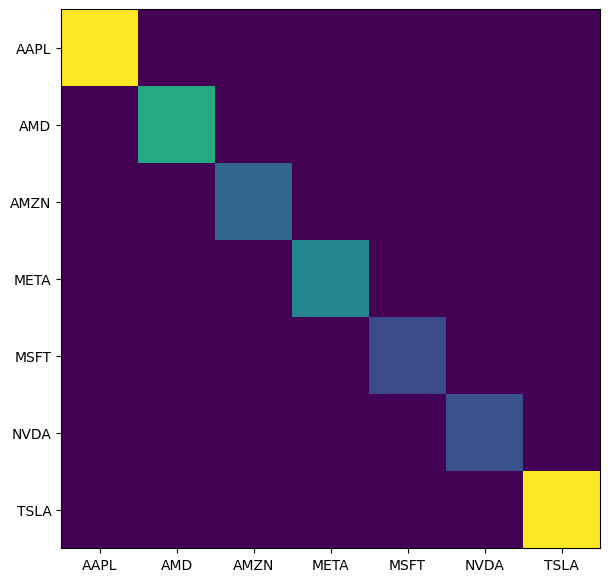

array([6.36894890e-05, 3.89966252e-05, 2.10670593e-05, 2.92956271e-05,
       1.43178093e-05, 1.60304755e-05, 6.36971609e-05])

In [59]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

np.diag(bl.omega)

# Posterior Returns

In [60]:
# Standard posterior returns
bl = BlackLittermanModel(
    covariance_matrix, 
    pi="market", 
    market_caps=market_caps, 
    risk_aversion=delta, 
    absolute_views=view_dict, 
    omega=bl.omega
)

bl_returns = bl.bl_returns()
bl_returns

# # Fear-greed posterior returns
# fear_greed_bl = BlackLittermanModel(
#     covariance_matrix, 
#     pi=prior, 
#     absolute_views=view_dict, 
#     view_confidences=
#     view_confidences
# )

# fear_greed_returns = fear_greed_bl.bl_returns()
# fear_greed_returns

# # Markov posterior returns
# # with the average dynamic covariance matrix
# markov_bl = BlackLittermanModel(
#     average_dynamic_cov,
#     pi=markov_prior,
#     absolute_views=markov_view_dict,
#     view_confidences=markov_view_confidences,
#     omega="idzorek",
# )

# markov_bl_returns = markov_bl.bl_returns()
# markov_bl_returns

Ticker
AAPL   -0.000346
AMD     0.032006
AMZN    0.063045
META    0.032267
MSFT    0.008064
NVDA    0.048751
TSLA    0.034675
dtype: float64

In [61]:
returns_df = pd.DataFrame([prior, bl_returns, pd.Series(view_dict)], index=["Prior", "Posterior", "Views"]).T
returns_df

# markov_returns_df = pd.DataFrame([markov_prior, markov_bl_returns, pd.Series(markov_view_dict)], index=["Prior", "Posterior", "Views"]).T
# markov_returns_df

,Prior,Posterior,Views
AAPL,0.020996,-0.000346,-0.035
AMD,0.021467,0.032006,0.020
AMZN,0.021075,0.063045,0.150
META,0.021161,0.032267,0.035
MSFT,0.020975,0.008064,-0.025
NVDA,0.021666,0.048751,0.100
TSLA,0.021480,0.034675,0.040


<Axes: >

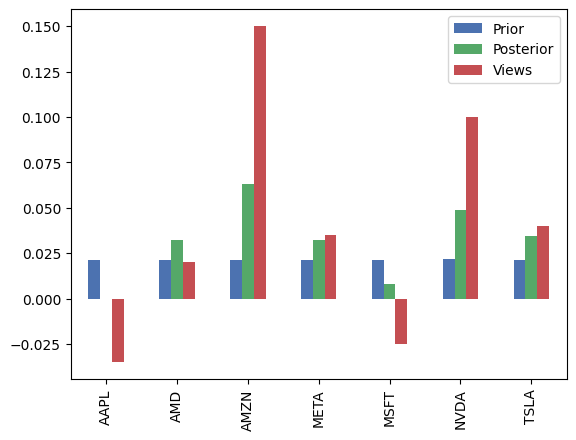

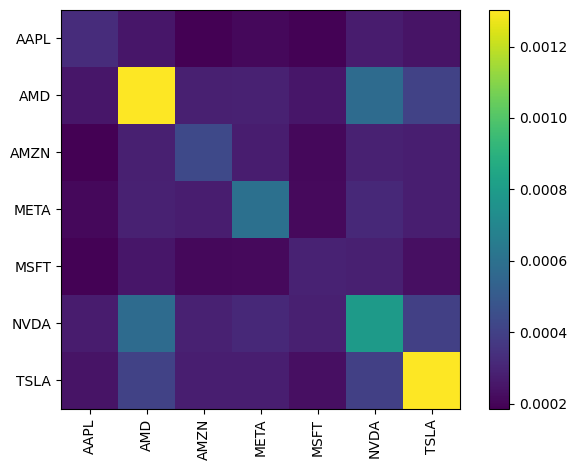

In [62]:
# visualisation of above
returns_df.plot.bar()

# Standard posterior covariance matrix
posterior_cov = bl.bl_cov()
plotting.plot_covariance(posterior_cov)

# # Markov posterior covariance matrix
# markov_posterior_cov = bl.bl_cov()
# plotting.plot_covariance(markov_posterior_cov, plot_correlation=True)

# Efficient Frontier Weights

In [51]:
# Standard efficient frontier and cleaned weights
ef = EfficientFrontier(bl_returns, posterior_cov)
weights = ef.min_volatility() # max_sharpe not working. look into this
cleaned_weights = ef.clean_weights()

# Markov-switching-adjusted frontier and cleaned weights
# markov_ef = EfficientFrontier(markov_bl_returns, markov_posterior_cov)
# markov_weights = markov_ef.min_volatility()  # Change to ef.max_sharpe() if needed
# markov_cleaned_weights = markov_ef.clean_weights()

In [53]:
print(f"Standard optimised weights: {cleaned_weights}")
cleaned_weights
# print(f"Markov optimised weights: {markov_cleaned_weights}")

Standard optimised weights: OrderedDict([('AAPL', 0.3542), ('AMD', 0.0), ('AMZN', 0.16226), ('META', 0.04388), ('MSFT', 0.43967), ('NVDA', 0.0), ('TSLA', 0.0)])


OrderedDict([('AAPL', 0.3542),
             ('AMD', 0.0),
             ('AMZN', 0.16226),
             ('META', 0.04388),
             ('MSFT', 0.43967),
             ('NVDA', 0.0),
             ('TSLA', 0.0)])

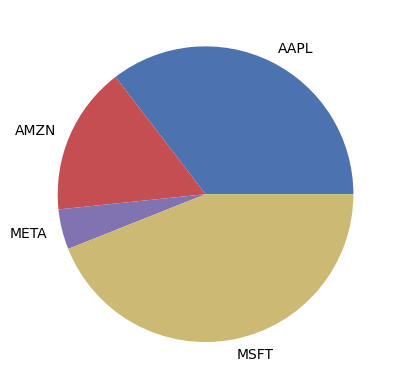

In [54]:
model_1_allocations = pd.Series(cleaned_weights).plot.pie()
# model_2_markov_allocations = pd.Series(markov_cleaned_weights).plot.pie()

# Performance Evaluation

In [ ]:
# returns
# annual returns (yearly avg)
# excess return (above risk free rate)

# risk-based metrics
# volatility (stdv)
# maximum drawdown

# risk-adjusted metrics
# sharpe, sortino, omega

# diversitifation metrics
# herfindahl-hischman index (measures portfolio concentration)
# number of unique holdings

# Benchmark Comparisons

In [ ]:
# traditional models
# standard MVO
# standard BL

# alternative models
# risk parity
# equal weighted
# markowitz portfolio

# Sensitivity Analysis

In [ ]:
# view confidence sensitivity
# markov switching model params sensitivity
# fear greed components sensitivity